In [1]:
import joblib
import numpy as np
import scipy.io as spio
from scipy.io import loadmat, matlab
import pandas as pd
import numpy as np
from scipy.interpolate import interp1d
from datetime import datetime

Let's train a Random Forest regression model for predicting absorption by coloreded dissolved organic material at 300 nm (aCDOM(300)) from remote sensing reflectance at the bands included in Sentinel-2 MSI sensor.

Our input data for this example is store in a MATLAB .mat file, but let's talk about the data structure in general.

We need two things:
1. in-situ measurements of aCDOM(300) (n)
2. coincident measurements of water leaving reflectance taken at the water surface (n x m)

A note, when developing a model it is best to use in-situ radiometric data as opposed to satellite derived radiometric measurments as it removes atmospheric complications from the physical relationship. These particular data were collected using a Spectra Vista Corp. (SVC) hyperspectral radiometer.


have been glint corrected with the three componenet (3C) glint model (https://gitlab.com/pgroetsch/rrs_model_3C).

In [2]:

# Extract the .mat file into a dictionary and then numpy.ndarray
mydata_dict = spio.loadmat('LIS_marshriver_V3.mat')
mydata_array = mydata_dict.get('lis_marshriver')

recordarr = np.rec.array(mydata_array)
lis_data = {}
myList = []

for field in recordarr.dtype.names: #iterates through field names of numpy array
    for array in recordarr[field]: #iterates through the array of each numpy array
        for value in array:
            myList.append(np.squeeze(value.flatten()))
            
    lis_data[field] = myList
    myList = []

Now we need to bring in the Spectral Response Functions (SRF) for Sentinel-2 MSI (https://sentinels.copernicus.eu/-/copernicus-sentinel-2c-spectral-response-functions).



In [3]:
s2a_df = pd.read_excel('S2-SRF_COPE-GSEG-EOPG-TN-15-0007_3.1.xlsx', sheet_name='Spectral Responses (S2A)')
s2a_df = s2a_df.loc[s2a_df.SR_WL >=350]
s2a_rsr_wave = s2a_df.SR_WL.values
s2a_rsr_bands = [443,492,560,665,705,740,783,842,865]
s2a_rsr = s2a_df[s2a_df.columns[1:11]].values

s2b_df = pd.read_excel('S2-SRF_COPE-GSEG-EOPG-TN-15-0007_3.1.xlsx', sheet_name='Spectral Responses (S2B)')
s2b_df = s2b_df.loc[s2b_df.SR_WL >=350]
s2b_rsr_wave = s2b_df.SR_WL.values
s2b_rsr_bands = [443,492,560,665,705,740,783,842,865]
s2b_rsr = s2b_df[s2b_df.columns[1:11]].values

/Users/opticslab/miniconda3/envs/cdom_ml/lib/python3.10/site-packages/openpyxl/worksheet/_read_only.py:85: UserWarning: Unknown extension is not supported and will be removed
  for idx, row in parser.parse():
/Users/opticslab/miniconda3/envs/cdom_ml/lib/python3.10/site-packages/openpyxl/worksheet/_read_only.py:85: UserWarning: Unknown extension is not supported and will be removed
  for idx, row in parser.parse():


Next, we'll create a function to apply a spectral weighting function, this code is adapted from Dirk Aurin's work (https://www.mdpi.com/2076-3417/8/12/2687)

In [4]:
def spectral_weighting_fun(spectra_in,wave_in,rsr,bands,rsr_wave,tol):
    # weights hyperspectral data to satellite response functions, matches multispectral within tolerance
    
    spectra_out = np.empty(len(bands)).flatten()
    spectra_out[:]=np.nan
    if spectra_in.size!=0:
        if np.sum(~np.isnan(spectra_in))>20:            
            for idx, band in enumerate(bands):
                interp = interp1d(wave_in, spectra_in)
                spectra_in_int = interp(rsr_wave[rsr_wave<=900])
                spectra_out[idx] = np.sum(spectra_in_int * rsr[rsr_wave<=900,idx] / np.sum(rsr[rsr_wave<=900,idx]))
        
        elif np.sum(~np.isnan(spectra_in))<20:
            for idx, wl in enumerate(wave_in):
                nearest_idx = (np.abs(bands - wl)).argmin()
                if abs(bands[nearest_idx]-wl) <= tol:
                    spectra_out[nearest_idx] = spectra_in[idx]
    return spectra_out

Now we'll apply the spectral weighting function to the input data. For this model we will only use the visible bands from Sentinel-2 MSI, which are the first four bands (443,492,560,665), as these are the bands in which organic material is optically active. For our application, we calculate the weighted arrays for the S2A and S2B sensors separately but then average them together. For now, this is a fine appraoch to test model efficacy. Ultimately, when we apply these models to indivudal sensors we will use unique models for S2A and S2B (they are very, very similar).

In [5]:
lis_data['s2a_weighted_Rrs'] = []
lis_data['s2a_bands'] = []
lis_data['s2b_weighted_Rrs'] = []
lis_data['s2b_bands'] = []

# Calculate weighted Rrs for each entry in mlr_dict
for ii in range(len(lis_data['rrs_3c_avg'])):
  
    s2a_weighted_Rrs = spectral_weighting_fun(lis_data['rrs_3c_avg'][ii],
                                              lis_data['wave_3c'][ii],
                                              s2a_rsr, s2a_rsr_bands, s2a_rsr_wave, tol=1)
    s2b_weighted_Rrs = spectral_weighting_fun(lis_data['rrs_3c_avg'][ii],
                                              lis_data['wave_3c'][ii],
                                              s2b_rsr, s2b_rsr_bands, s2b_rsr_wave, tol=1)
    

    lis_data['s2a_weighted_Rrs'].append(s2a_weighted_Rrs)  #  Append instead of assigning to an index
    lis_data['s2a_bands'].append(s2a_rsr_bands)  
    lis_data['s2b_weighted_Rrs'].append(s2b_weighted_Rrs)  
    lis_data['s2b_bands'].append(s2b_rsr_bands)  

all_s2a_weighted_Rrs = [arr[:4] for arr in lis_data['s2a_weighted_Rrs']]
all_s2b_weighted_Rrs = [arr[:4] for arr in lis_data['s2b_weighted_Rrs']]

all_weighted_Rrs = np.mean([all_s2a_weighted_Rrs, all_s2b_weighted_Rrs],axis=0)


Next, we will format our input feature array. The input features for this model indlude:

1. Rrs(443)
2. Rrs(490)
3. Rrs(560)
4. Rrs(665)
5. Rrs(492)/Rrs(665)
6. Rrs(560)/Rrs(665)
7. Rrs(492)/Rrs(560)
8. Sine array
9. Cosine Array

These inputs are based on the model developed in Mendendez & Tzorztiou, 2025 (https://www.sciencedirect.com/science/article/pii/S1569843225000366?via%3Dihub)

The sine and cosine arrays are a cyclically encoded representation of the month of the year that the in-situ measurement was taken in. Seasonal variations in CDOM can be quite large and this feature helps inform the model on this variability. The encoding steps are shown below.

In [6]:
# Stack Rrs arrays to create a 2D array
Rrs_matrix = np.vstack(all_weighted_Rrs)

# Print the shape of Rrs_matrix to debug
print(f"Shape of Rrs_matrix: {Rrs_matrix.shape}")  # Should be (n, 4)

# Assuming month_value and cycle_length are defined
month_value =  np.array(lis_data['month'])[:] # Example: July
cycle_length = 12  # Total months

# Cyclic encoding for the month
sine_transform = np.sin(2 * np.pi * month_value / cycle_length)
cosine_transform = np.cos(2 * np.pi * month_value / cycle_length)

# # Create sine and cosine arrays
# desired_length = Rrs_matrix.shape[0]
sine_array = sine_transform.reshape(-1, 1)
cosine_array = cosine_transform.reshape(-1, 1)


# Calculate ratios ensuring they result in (7, 1)
ratio_492_665 = Rrs_matrix[:, 1:2] / Rrs_matrix[:, 3:4]  # Shape (7, 1)
ratio_560_665 = Rrs_matrix[:, 2:3] / Rrs_matrix[:, 3:4]  # Shape (7, 1)
ratio_492_560 = Rrs_matrix[:, 1:2] / Rrs_matrix[:, 2:3]  # Shape (7, 1)

# Print shapes of ratios
print(f"Shape of ratio_492_665: {ratio_492_665.shape}")  # Should be (7, 1)
print(f"Shape of ratio_560_665: {ratio_560_665.shape}")  # Should be (7, 1)
print(f"Shape of ratio_492_560: {ratio_492_560.shape}")  # Should be (7, 1)

# Concatenate Rrs features with sine/cosine month features
msi_matrix_for_alg = np.concatenate((Rrs_matrix, 
                                      ratio_492_665, 
                                      ratio_560_665, 
                                      ratio_492_560, 
                                      sine_array, 
                                      cosine_array), axis=1)

# Final shape check
print(f"Final shape of msi_matrix_for_alg: {msi_matrix_for_alg.shape}")  

Shape of Rrs_matrix: (97, 4)
Shape of ratio_492_665: (97, 1)
Shape of ratio_560_665: (97, 1)
Shape of ratio_492_560: (97, 1)
Final shape of msi_matrix_for_alg: (97, 9)


In [7]:

from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

X = msi_matrix_for_alg
y = np.array(lis_data['acdom300'])

r2_sv = []
train_indexes_list = []
test_indexes_list = []
feature_impt_sv = []



# Define ranges or bins
# Striating the data ensures good representation of all values in both training and testing data
ranges = [(0, 5), (5,10), (10 ,15),(15 ,25)]  # Example ranges

# Initialize lists for train and test
X_train, X_test, y_train, y_test = [], [], [], []
train_indexes, test_indexes = [], []

for r in ranges:
    # Filter data within the range
    mask = (y >= r[0]) & (y < r[1])
    X_range, y_range = X[mask], y[mask]

    indexes = np.where(mask)[0]
    # Split within this range
    #X_train_range, X_test_range, y_train_range, y_test_range = train_test_split(X_range, y_range, test_size=0.2)
    
    X_train_range, X_test_range, y_train_range, y_test_range, idx_train_range, idx_test_range = train_test_split(
        X_range, y_range, indexes, test_size=0.2
    )
    
    # Append the indexes to the overall train/test lists
    train_indexes.extend(idx_train_range)
    test_indexes.extend(idx_test_range)

    

    # Append to the overall train/test lists
    X_train.append(X_train_range)
    X_test.append(X_test_range)
    y_train.append(y_train_range)
    y_test.append(y_test_range)
    
    # Store the train and test indexes for this iteration
train_indexes_list.append(train_indexes)
test_indexes_list.append(test_indexes)

# Convert lists back to arrays
X_train = np.concatenate(X_train)
X_test = np.concatenate(X_test)
y_train = np.concatenate(y_train)
y_test = np.concatenate(y_test)


# Fitting Random Forest Regression to the dataset
regressor = RandomForestRegressor(n_estimators=1000, random_state=12, oob_score=True)

# Fit the regressor with x and y data
regressor.fit(X_train,np.log(y_train))

# Evaluating the model
# Access the OOB Score
oob_score = regressor.oob_score_


# Making predictions on the same data or new data
predictions = np.exp(regressor.predict(X_test))
predict_train = np.exp(regressor.predict(X_train))

# # Evaluating the model
mse_test = mean_squared_error(y_test, predictions)
mse_train = mean_squared_error(y_train, predict_train)
# print(f'Mean Squared Error: {mse}')

r2_test = r2_score(y_test, predictions)
r2_train = r2_score(y_train, predict_train)



Finally, let's examine the fit of the model using standard statistical tests.

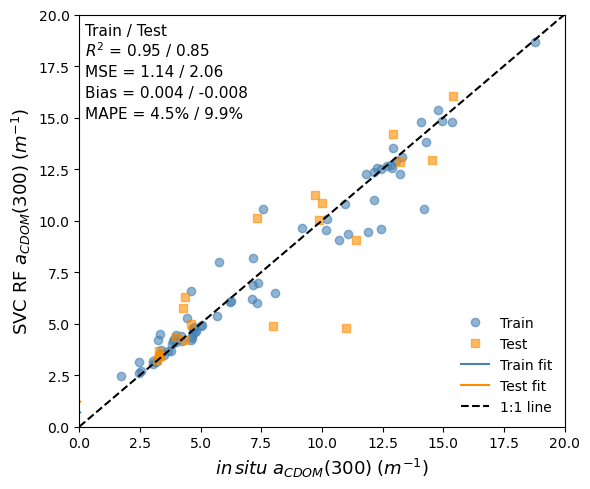

In [8]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression

# --- Define Metrics ---
def _bias_(x, y, n):
    return 10 ** (np.nansum(np.log10(y) - np.log10(x)) / n) - 1

def root_mean_square_error(x, y, n):
    return (np.nansum((y - x) ** 2) / n) ** 0.5

def mean_absolute_percent_error(x, y):
    return np.nanmedian(np.abs(y - x) / x) * 100

# --- Compute Metrics ---
n_train = np.count_nonzero(~np.isnan(y_train))
n_test = np.count_nonzero(~np.isnan(y_test))

bias_train = _bias_(y_train, predict_train, n_train)
bias_test = _bias_(y_test, predictions, n_test)

rmse_train = root_mean_square_error(y_train, predict_train, n_train)
rmse_test = root_mean_square_error(y_test, predictions, n_test)

mape_train = mean_absolute_percent_error(y_train, predict_train)
mape_test = mean_absolute_percent_error(y_test, predictions)

# --- Fit regression lines ---
reg_train = LinearRegression().fit(y_train.reshape(-1, 1), predict_train)
reg_test = LinearRegression().fit(y_test.reshape(-1, 1), predictions)
x_vals = np.linspace(0.01, 0.03, 100)

# --- Plotting ---
fig, ax = plt.subplots(figsize=(6, 5))

# Scatter plots
ax.plot(y_train, predict_train, 'o', markersize=6, alpha=0.6, label='Train', color='steelblue')
ax.plot(y_test, predictions, 's', markersize=6, alpha=0.6, label='Test', color='darkorange')

# Regression lines
ax.plot(x_vals, reg_train.predict(x_vals.reshape(-1, 1)), '-', color='steelblue', label='Train fit')
ax.plot(x_vals, reg_test.predict(x_vals.reshape(-1, 1)), '-', color='darkorange', label='Test fit')

# 1:1 line
ax.plot([0, 20], [0, 20], 'k--', label='1:1 line')

# Axis settings
ax.set_xlim([0, 20])
ax.set_ylim([0, 20])
ax.set_xlabel(r'$\it{in \, situ} \; \it{a}_{CDOM}(300) \;(m^{-1})$', fontsize=13)
ax.set_ylabel(r'SVC RF $\it{a}_{CDOM}(300) \;(m^{-1})$', fontsize=13)

# Metrics annotations
ax.text(0.25, 19, 'Train / Test', fontsize=11)
ax.text(0.25, 18, f'$R^2$ = {r2_train:.2f} / {r2_test:.2f}', fontsize=11)
ax.text(0.25, 17, f'MSE = {rmse_train:.2f} / {rmse_test:.2f}', fontsize=11)
ax.text(0.25, 16, f'Bias = {bias_train:.3f} / {bias_test:.3f}', fontsize=11)
ax.text(0.25, 15, f'MAPE = {mape_train:.1f}% / {mape_test:.1f}%', fontsize=11)

# Legend
ax.legend(loc='lower right', fontsize=10, frameon=False)

plt.tight_layout()
plt.show()

